In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Augment clusters with preferred names

Load clusters and preferred tree names, and determine which common tree names do not appear in the clusters.

Use a bi-encoder followed by a cross-encoder to determine which cluster they should go into.

In [25]:
from collections import Counter
import json
import os
import re

import numpy as np
from sentence_transformers.cross_encoder import CrossEncoder
import torch
from tqdm.auto import tqdm

from nama.data.filesystem import download_file_from_s3, save_file
from nama.data.normalize import normalize
from nama.data.utils import read_csv
from nama.models.biencoder import BiEncoder
from nama.models.tokenizer import get_tokenize_function_and_vocab
from nama.models.utils import get_cross_encoder_score, top_similar_names

In [17]:
# config
# TODO run both given and surname
given_surname = "given"
# given_surname = "surname"

max_tokens = 10
tokenizer_max_length = 32
bi_encoder_vocab_size = 2048
num_epochs = 8
embedding_dim = 256
learning_rate = 0.00005 
cross_encoder_vocab_size = 265
linkage = "average"
similarity_threshold = 0.10 if given_surname == "given" else 0.25
cluster_freq_normalizer = "none"

# hyperparameters
top_n_names = 117000
common_name_threshold = 105

basenames_path = "../references/basenames-20100616.txt"
pref_path = f"s3://fs-nama-data/2024/familysearch-names/processed/tree-preferred-{given_surname}-aggr.csv.gz"
tokenizer_path=f"s3://fs-nama-data/2024/nama-data/data/models/fs-{given_surname}-subword-tokenizer-{bi_encoder_vocab_size}.json"
bi_encoder_path = f"s3://fs-nama-data/2024/nama-data/data/models/bi_encoder-ce-{given_surname}-{num_epochs}-{embedding_dim}-{num_epochs}-{bi_encoder_vocab_size}-{learning_rate}.pth"
cross_encoder_dir = f"../data/models/cross-encoder-{given_surname}-{cross_encoder_vocab_size}"
cross_encoder_dir_s3 = f"s3://fs-nama-data/2024/nama-data/data/models/cross-encoder-{given_surname}-{cross_encoder_vocab_size}/"
clusters_path = f"s3://fs-nama-data/2024/nama-data/data/processed/clusters_{given_surname}-{linkage}-{similarity_threshold}-{cluster_freq_normalizer}.json"

augmented_clusters_path = f"s3://fs-nama-data/2024/nama-data/data/processed/clusters_{given_surname}-{linkage}-{similarity_threshold}-{cluster_freq_normalizer}-augmented.json"

In [4]:
torch.cuda.empty_cache()
print(torch.cuda.is_available())
print("cuda total", torch.cuda.get_device_properties(0).total_memory)
print("cuda reserved", torch.cuda.memory_reserved(0))
print("cuda allocated", torch.cuda.memory_allocated(0))

True
cuda total 8141471744
cuda reserved 0
cuda allocated 0


## Load data

In [6]:
name_cluster = {}             # name -> cluster label
cluster_names = {}            # cluster label -> names
cluster_centroids = []        # centroid for each cluster
cluster_centroid_labels = []  # label for each cluster

path = download_file_from_s3(clusters_path) if clusters_path.startswith("s3://") else clusters_path
with open(path, 'r') as f:
    clusters = json.load(f)  # cluster label -> names, centroid

for label, cluster in clusters.items():
    cluster_names[label] = set(cluster['names'])
    for name in cluster['names']:
        name_cluster[name] = label
    cluster_centroid_labels.append(label)
    cluster_centroids.append(np.array(cluster['centroid']))
cluster_centroid_labels = np.array(cluster_centroid_labels)

print(len(cluster_names), len(name_cluster))

15476 95997


In [8]:
# load pref names
path = download_file_from_s3(pref_path) if pref_path.startswith("s3://") else pref_path
pref_df = read_csv(path)

In [9]:
# get total frequency, including names w frequency=1 that aren't in pref_df
total_freq = sum(pref_df['frequency']) + len(pref_df[pref_df['frequency'] == 2]) * 2
total_freq

1609369389

In [18]:
# calculate % of total frequency of the top N names 
freq = sum(pref_df['frequency'][:top_n_names])
print(freq/total_freq)

0.9833570253149633


In [19]:
# create common names pref names that occur >= common_name_threshold
common_names = [name for name, freq in zip(pref_df['name'], pref_df['frequency']) \
                if len(name) > 1 and re.fullmatch(r'[a-z]+', name) and freq >= common_name_threshold]
len(common_names)

134857

In [20]:
# read basenames
basenames = {}
path = download_file_from_s3(basenames_path) if basenames_path.startswith("s3://") else basenames_path
with open(path) as f:
    for line in f:
        name, basename = line.strip().split('|')
        basenames[name] = basename

In [21]:
print(basenames['mcwilliams'])
len(basenames)

williams


85108

In [23]:
# load tokenize function
path = download_file_from_s3(tokenizer_path) if tokenizer_path.startswith("s3://") else tokenizer_path
tokenize, tokenizer_vocab = get_tokenize_function_and_vocab(tokenizer_path=path, max_tokens=max_tokens)
len(tokenizer_vocab)

2048

In [24]:
# load bi-encoder
path = download_file_from_s3(bi_encoder_path) if bi_encoder_path.startswith("s3://") else bi_encoder_path
bi_encoder_model = torch.load(path)
bi_encoder_model.eval()

/tmp/ipykernel_3819154/3861995143.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bi_encoder_model = torch.load(path)


BiEncoder(
  (embedding): Embedding(2048, 256)
  (positional_embedding): Embedding(10, 256)
  (pooling): AdaptiveAvgPool1d(output_size=1)
)

In [26]:
# download cross encoder
for filename in [
    'CECorrelationEvaluator_dev_results.csv',
    'config.json',
    'merges.txt',
    'special_tokens_map.json',
    'tokenizer_config.json',
    'tokenizer.json',
    'vocab.json',
    'model.safetensors',
]:
    print(filename)
    cross_encoder_dir_filename = os.path.join(cross_encoder_dir, filename)
    if not os.path.exists(cross_encoder_dir_filename):
        print('downloading', filename)
        download_file_from_s3(cross_encoder_dir_s3+filename, cross_encoder_dir_filename)

CECorrelationEvaluator_dev_results.csv
config.json
merges.txt
special_tokens_map.json
tokenizer_config.json
tokenizer.json
vocab.json
model.safetensors


In [27]:
# load cross encoder model
ce_model = CrossEncoder(cross_encoder_dir, max_length=tokenizer_max_length)

## Which names are not in the clusters?

In [29]:
print_cnt = 10
unseen_names = []
for ix, name in enumerate(common_names):
    name_pieces = normalize(name, is_surname=given_surname=='surname', dont_return_empty=False)
    if len(name_pieces) != 1:
        continue
    name = name_pieces[0]
    if ix % 50000 == 0 and len(unseen_names) > 0:
        print(ix, len(unseen_names))
        print_cnt = 10
    if name in name_cluster:
        continue
    unseen_names.append(name)
    if print_cnt > 0:
        print('   ', ix, name)
        print_cnt -= 1

    321 delaluz
    441 delossantos
    539 delatrinidad
    541 desantiago
    567 delosdolores
    570 delosangeles
    876 delosreyes
    944 delaencarnacion
    950 ssi
    1000 delaconcepcion
50000 8971
    50002 quillen
    50006 westerman
    50009 wyck
    50013 kio
    50015 lorentsen
    50018 mcauley
    50025 aurita
    50027 fransdr
    50029 domenicantonia
    50034 doi
100000 33589
    100001 torkildsdatter
    100002 cuy
    100006 bairstow
    100007 ilifonso
    100008 palmarino
    100009 camy
    100011 malto
    100015 shangara
    100019 quentze
    100020 rawles


In [30]:
print(len(unseen_names))
unseen_names[:10]

58035


['delaluz',
 'delossantos',
 'delatrinidad',
 'desantiago',
 'delosdolores',
 'delosangeles',
 'delosreyes',
 'delaencarnacion',
 'ssi',
 'delaconcepcion']

### get name embeddings

In [49]:
def get_embedding(name):
    embedding = bi_encoder_model.get_embedding(tokenize(name)) 
    return embedding

In [50]:
name_embeddings_names = np.array(list(name_cluster.keys()))
name_embeddings = [get_embedding(name) for name in name_cluster.keys()]

## Figure out which cluster to put the names into

In [51]:
def get_nearest_bi_encoder_names(name, threshold=0.3, limit=10):
    embedding = get_embedding(name)
    return top_similar_names(embedding, name_embeddings, name_embeddings_names, threshold, limit)

def get_bi_encoder_score(name, other_name):
    emb1 = get_embedding(name)
    emb2 = get_embedding(other_name)
    emb1 = emb1 / np.linalg.norm(emb1)
    emb2 = emb2 / np.linalg.norm(emb2)
    result = np.dot(emb1, emb2)
    return result

def get_bi_encoder_cluster_score(name, cluster, use_max=False):
    scores = []
    # print('cluster', cluster)
    for cluster_name in cluster_names[cluster]:
        score = get_bi_encoder_score(name, cluster_name)
        # print('  score', name, cluster_name, score)
        scores.append(score)
    return max(scores) if use_max else sum(scores)/len(scores)

def get_nearest_bi_encoder_cluster_score(name, other_names, limit=10, use_max=False):
    # get most-frequently occurring clusters
    clusters = Counter()
    for other_name in other_names:
        if other_name not in name_cluster:
            continue
        cluster = name_cluster[other_name]
        clusters[cluster] += 1
    if len(clusters) == 0:
        return None, None
    # get nearest cluster
    max_cluster = None
    max_score = None
    for cluster, count in clusters.most_common(limit):
        # print('cluster, count', cluster, count)
        score = get_bi_encoder_cluster_score(name, cluster, use_max=use_max)
        # print('   score', score)
        if max_score is None or score > max_score:
            max_score = score
            max_cluster = cluster
    return max_cluster, max_score

In [52]:
def get_cross_encoder_cluster_score(name, cluster, use_max=False):
    scores = []
    # print('cluster', cluster)
    for cluster_name in cluster_names[cluster]:
        score = get_cross_encoder_score(name, cluster_name, ce_model)
        # print('   score', name, cluster_name, score)
        scores.append(score)
    return max(scores) if use_max else sum(scores)/len(scores)

def get_nearest_cross_encoder_cluster_score(name, other_names, limit=10, use_max=False):
    # get most-frequently occurring clusters
    clusters = Counter()
    for other_name in other_names:
        if other_name not in name_cluster:
            continue
        cluster = name_cluster[other_name]
        clusters[cluster] += 1
    if len(clusters) == 0:
        return None, None
    # get nearest cluster
    max_cluster = None
    max_score = None
    for cluster, count in clusters.most_common(limit):
        # print('cluster, count', cluster, count)
        score = get_cross_encoder_cluster_score(name, cluster, use_max=use_max)
        # print('   score', score)
        if max_score is None or score > max_score:
            max_score = score
            max_cluster = cluster
    return max_cluster, max_score

In [53]:
# test
name = 'ivanovna'
names, scores = get_nearest_bi_encoder_names(name, limit=20)
print(names, scores)
# names = names[1:]
# scores = scores[1:]
ce_cluster, ce_score = get_nearest_cross_encoder_cluster_score(name, names)
print('cross-encoder', ce_cluster, ce_score)

be_cluster, be_score = get_nearest_bi_encoder_cluster_score(name, names)
print('bi-encoder', be_cluster, be_score)

['yovanna' 'alexandrovna' 'ivanna' 'gulovna' 'iovan' 'ivan' 'ioanna'
 'iveranna' 'ivo' 'ronov' 'iverna' 'ivona' 'ivana' 'yovan' 'donovan'
 'suvannah' 'giovanna' 'svanov' 'ioana' 'milovan'] [0.7754174  0.75629807 0.70069605 0.69289124 0.62945795 0.6225212
 0.6218858  0.61720634 0.608515   0.5933338  0.5890293  0.5865956
 0.57856953 0.57738674 0.57100356 0.57084405 0.56002235 0.55434376
 0.55254376 0.5502881 ]
cross-encoder abraham/iveranna 0.4225682
bi-encoder abraham/iveranna 0.61720634


In [55]:
def sample_names(cluster):
    if not cluster:
        return ''
    return ' '.join(list(cluster_names[cluster])[:8])

In [56]:
print(len(cluster_names), len(name_cluster))

15476 95997


In [57]:
testing = False

unseen_names_set = set(unseen_names)
n_new_clusters = 0

for name in unseen_names[:1000] if testing else tqdm(unseen_names, mininterval=1.0):
    # get fs vote
    # fs_cluster, fs_score = get_fs_cluster_score(name)
    # if fs_cluster is not None:
    #     votes[fs_cluster] += fs_score * fs_weight + fs_boost

    # handle prefixed surnames by adding the prefixed surname to the cluster of the basename
    if name in basenames:
        basename = basenames[name]
        if basenames[name] in name_cluster:
            # add the prefixed surname to the cluster for the basename
            cluster = name_cluster[basenames[name]]
            name_cluster[name] = cluster
            cluster_names[cluster].add(name)
            continue
    else:
        basename = name
        
    cluster = None
    score = 0.0
    # get nearby names
    names, scores = get_nearest_bi_encoder_names(basename)
    if len(names) > 0:
        # get cross-encoder vote
        cluster, score = get_nearest_cross_encoder_cluster_score(basename, names)
    
    # print stuff if testing
    if testing and abs(score - similarity_threshold) < 0.05:
        print()
        print(name)
        # print('   fs', fs_cluster, fs_score, sample_names(fs_cluster))
        print('   ce', cluster, score, sample_names(cluster))
        if score > similarity_threshold:
            print('WINNER', cluster, score)
        continue

    # add name to existing cluster, or create a new cluster
    if testing and name != basename:
        print('basename not found', name, basename, cluster)
    if score >= similarity_threshold:
        name_cluster[name] = cluster
        cluster_names[cluster].add(name)
    else:
        n_new_clusters += 1
        name_cluster[name] = name
        cluster_names[name] = {name}

    # add embedding
    name_embeddings_names = np.append(name_embeddings_names, [name], axis=0)
    name_embeddings = np.append(name_embeddings, [get_embedding(name)], axis=0)

print('new clusters', n_new_clusters)

  0%|          | 0/58035 [00:00<?, ?it/s]

new clusters 757


In [59]:
print(len(cluster_names), len(name_cluster))

16233 154032


## Save augmented clusters

In [60]:
def get_centroid(names):
    total_embedding = None
    for name in names:
        embedding = get_embedding(name)
        if total_embedding is None:
            total_embedding = embedding
        else:
            total_embedding += embedding
    # get average embedding
    total_embedding = total_embedding / len(names)
    # normalize
    total_embedding = total_embedding / np.linalg.norm(total_embedding)
    return total_embedding

In [61]:
augmented_clusters_path

's3://fs-nama-data/2024/nama-data/data/processed/clusters_given-average-0.1-none-augmented.json'

In [62]:
clusters = {}
for label, names in cluster_names.items():
    centroid = get_centroid(names)
    clusters[label] = {"names": list(names), "centroid": centroid.tolist()}

In [63]:
save_file(augmented_clusters_path,
          lambda local_out_path : json.dump(clusters, open(local_out_path, 'w'), indent=2))

## Compare centroids

In [64]:
path = download_file_from_s3(augmented_clusters_path) if augmented_clusters_path.startswith("s3://") else augmented_clusters_path
with open(path, 'r') as f:
    augmented_clusters = json.load(f)  # cluster label -> names, centroid

path = download_file_from_s3(clusters_path) if clusters_path.startswith("s3://") else clusters_path
with open(path, 'r') as f:
    clusters = json.load(f)  # cluster label -> names, centroid
    

In [65]:
sims = []
cnt = 0
for label in clusters:
    centroid = clusters[label]['centroid']
    if label not in augmented_clusters:
        print('Should not happen', label)
        continue
    aug_centroid = augmented_clusters[label]['centroid']
    aug_centroid = aug_centroid / np.linalg.norm(aug_centroid)
    centroid = centroid / np.linalg.norm(centroid)
    sim = np.dot(centroid, aug_centroid)
    if sim < 0.8:
        cnt += 1
        print()
        print(label)
        print('1', len(clusters[label]['names']), clusters[label]['names'])
        print('2', len(augmented_clusters[label]['names']), augmented_clusters[label]['names'])
    sims.append(sim)
cnt


aage/ouwe
1 1 ['ouwe']
2 7 ['nwaugo', 'owusu', 'ouwes', 'nwosu', 'nwogu', 'nwaogu', 'ouwe']

aaltje/altino
1 1 ['altino']
2 7 ['alti', 'aldiva', 'adaltiva', 'altivo', 'atractiva', 'altino', 'altiva']

aaron/irion
1 1 ['irion']
2 3 ['irion', 'jion', 'jio']

abbe/abon
1 1 ['abon']
2 4 ['abon', 'abayon', 'ayon', 'ayson']

abdool/abdool
1 1 ['abdool']
2 5 ['abdom', 'abdou', 'abdool', 'adou', 'adaku']

abraham/iveranna
1 1 ['iveranna']
2 18 ['ioakimova', 'ioannov', 'ionova', 'yanovna', 'ioannova', 'ivanivna', 'iudovna', 'ivanova', 'ivanovna', 'ioanovna', 'iveranna', 'iwanowna', 'ioanova', 'ionovna', 'minovna', 'ioannovna', 'isaakovna', 'isakovna']

acacia/achatz
1 1 ['achatz']
2 6 ['schantz', 'schatz', 'scheetz', 'achatz', 'schutz', 'shantz']

achille/acles
1 1 ['acles']
2 4 ['avle', 'acles', 'aviles', 'avilez']

acua/acua
1 1 ['acua']
2 10 ['akosuah', 'akoua', 'afua', 'akossiwa', 'akosua', 'acuna', 'acua', 'ahoua', 'akua', 'akuna']

ada/adabell
1 1 ['adabell']
2 4 ['adabell', 'aderval', '

598

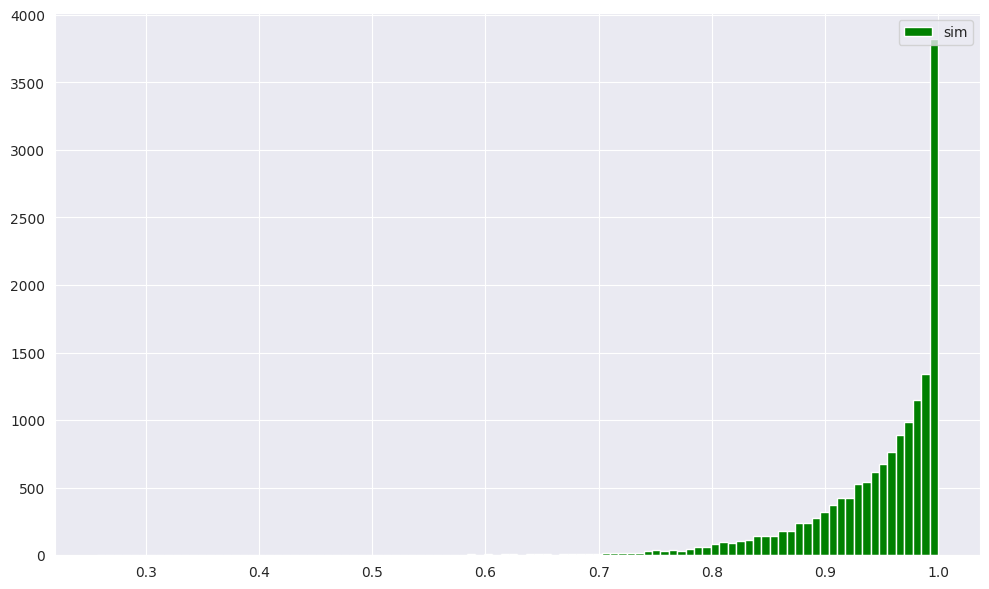

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(sims, bins=100, label="sim", color='green')
plt.legend(loc='upper right')
# Show the plot
plt.tight_layout()
plt.show()